# Loading necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow
import torch
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
seed = 221
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load diabetes dataset

In [3]:
diabetes = pd.read_csv("/kaggle/input/diabetes-data-set/diabetes.csv", index_col = 0)
diabetes

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,,,,,,,,
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...
10,101,76,48,180,32.9,0.171,63,0
2,122,70,27,0,36.8,0.340,27,0
5,121,72,23,112,26.2,0.245,30,0


In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 6 to 1
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   768 non-null    int64  
 1   BloodPressure             768 non-null    int64  
 2   SkinThickness             768 non-null    int64  
 3   Insulin                   768 non-null    int64  
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    int64  
 7   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 54.0 KB


In [5]:
diabetes.isnull().sum()

Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
(diabetes < 0).sum()

Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
diabetes.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,,,,,,,,
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


# Preprocessing data

In [8]:
X = diabetes.drop(columns = ['Outcome'], axis = 1)
y = diabetes['Outcome']

In [9]:
def replacement(df, method="mean", factor=1.5):

    df = df.copy()

    columns = df.select_dtypes(include=[np.number]).columns
    for column in columns:

        Q1 = df[column].quantile(0.25)  
        Q3 = df[column].quantile(0.75)  
        IQR = Q3 - Q1

        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        if method == "mean":
            replacement_value = df[column].mean()
        elif method == "median":
            replacement_value = df[column].median()
        else:
            raise ValueError("Replacement method should be " + "mean " + "or" + " median")

        df[column] = df[column].apply(
            lambda x: replacement_value if x < lower_bound or x > upper_bound else x
        )
    
    return df

In [10]:
X = replacement(X, method = "mean")

In [11]:
column_names = diabetes.columns.values
column_names

array(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'], dtype=object)

In [12]:
# Initialize the standardize scaler
scaler = StandardScaler()

# Standardize all independent variables
diabetes[column_names[:-1]] = scaler.fit_transform(diabetes[column_names[:-1]])

**train_test ratio = 7:3, random_state = seed**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Train the Bagging Classifier (Base Estimator: Decision Tree)

**Number of estimators is 100**

> **With Boostrapping**

In [14]:
bag_clf = BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=seed)

In [15]:
bag_clf

BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=221)

In [16]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=221)

In [17]:
pred = bag_clf.predict(X_test)
pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [18]:
import random

def generate_values():
    # Define realistic ranges for each feature
    glucose = random.uniform(50, 200)  # mg/dL
    blood_pressure = random.uniform(60, 120)  # mm Hg
    skin_thickness = random.uniform(10, 50)  # mm
    insulin = random.uniform(15, 300)  # µU/mL
    bmi = random.uniform(18.5, 50)  # kg/m^2
    diabetes_pedigree_function = random.uniform(0.1, 2.5)  # no unit
    age = random.randint(10, 90)  # years

    return [
        round(glucose, 2),
        round(blood_pressure, 2),
        round(skin_thickness, 2),
        round(insulin, 2),
        round(bmi, 2),
        round(diabetes_pedigree_function, 2),
        age
    ]

def generate_test_case():
    header = [
        "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
    ]
    data = generate_values()

    return pd.DataFrame([data], columns=header)

In [19]:
test = generate_test_case()
print(test)
bag_clf.predict(test)

   Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0   120.45         119.54          10.09   272.05  41.41   

   DiabetesPedigreeFunction  Age  
0                      2.11   14  


array([0])

In [20]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       139
           1       0.74      0.59      0.65        92

    accuracy                           0.75       231
   macro avg       0.75      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231



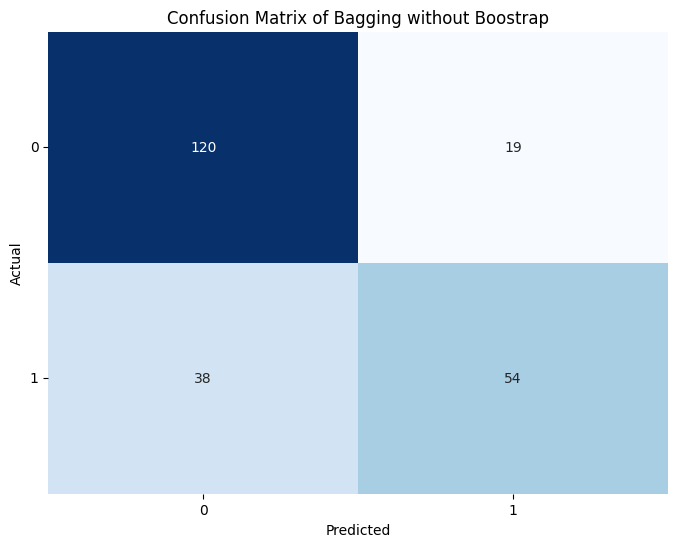

In [21]:
cm_ = confusion_matrix(y_test, pred)
labels = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Bagging without Boostrap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()

> Without Boostrapping

In [22]:
bag_clf_ = BaggingClassifier(n_estimators=100, bootstrap=False, n_jobs=-1, random_state=seed)

In [23]:
bag_clf_

BaggingClassifier(bootstrap=False, n_estimators=100, n_jobs=-1,
                  random_state=221)

In [24]:
bag_clf_.fit(X_train, y_train)

BaggingClassifier(bootstrap=False, n_estimators=100, n_jobs=-1,
                  random_state=221)

In [25]:
pred_ = bag_clf_.predict(X_test)
pred_

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [26]:
test = generate_test_case()
print(test)
bag_clf_.predict(test)

   Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0    53.29          72.76          26.25   190.96  48.53   

   DiabetesPedigreeFunction  Age  
0                      1.98   13  


array([0])

In [27]:
print(classification_report(y_test, pred_))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       139
           1       0.65      0.58      0.61        92

    accuracy                           0.71       231
   macro avg       0.69      0.68      0.69       231
weighted avg       0.70      0.71      0.70       231



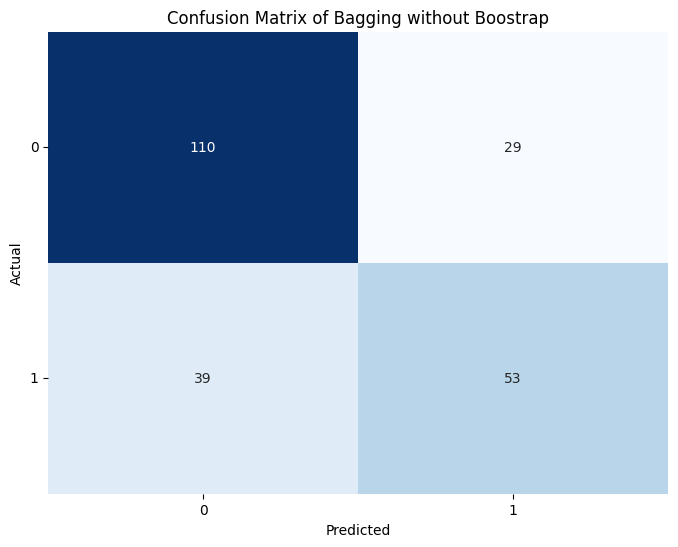

In [28]:
cm_ = confusion_matrix(y_test, pred_)
labels = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Bagging without Boostrap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()

> 